In [39]:
# imports
import numpy as np
import pandas as pd

# modelling
from sklearn import datasets
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset split: 56000 train rows 56000 label rows
Dataset split: 14000 test rows 14000 label rows


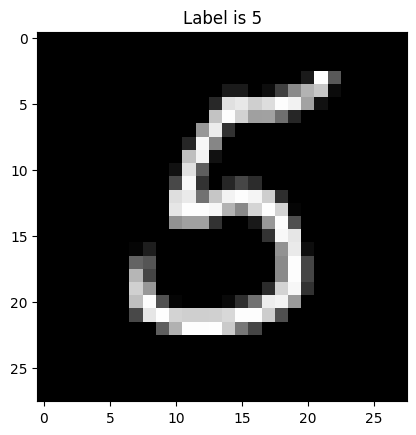

In [40]:
# Initialize
mnist = datasets.fetch_openml("mnist_784")
X, y = mnist.data, mnist.target

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# digits = load_digits()
print(f"Dataset split: {len(x_train)} train rows",
          f"{len(y_train)} label rows")

print(f"Dataset split: {len(x_test)} test rows",
          f"{len(y_test)} label rows")

point = np.array(x_train.iloc[0], dtype='uint8')
point = point.reshape((28, 28))

plt.title('Label is {label}'.format(label=y_train.iloc[0]))
plt.imshow(point, cmap='gray')
plt.show()

In [41]:
print(x_train.shape)
print(x_test.shape)

(56000, 784)
(14000, 784)


In [42]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# convert labels to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [43]:
# Convert labels to binary format (0 for normal instances, 1 for anomalies)
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
y_test_binary = y_test_binary[:, 0]  # Considering only one class as positive

In [44]:
# Create and train an Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(x_train)

IsolationForest(contamination=0.1, random_state=42)

In [45]:
prediction = model.predict(x_test)

In [46]:
# Anomalies are predicted as -1, so we will save their indexes
anomaly_indexes = np.where(prediction == -1)[0]

In [47]:
# Print the number of anomalies and accuracy
print("Number of anomalies:", len(anomaly_indexes))
print("Accuracy:", accuracy_score(y_test, (prediction == 1)))

Number of anomalies: 1373
Accuracy: 0.14714285714285713


In [48]:
# Print the indexes of anomalies
print("Indexes of Anomalies:")
print(anomaly_indexes)

Indexes of Anomalies:
[    0     5    12 ... 13986 13995 13996]


In [49]:
# Create a classification report
report = classification_report(y_test, (prediction == -1), target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.66      0.13      1343
           1       0.00      0.00      0.00      1600
           2       0.00      0.00      0.00      1380
           3       0.00      0.00      0.00      1433
           4       0.00      0.00      0.00      1295
           5       0.00      0.00      0.00      1273
           6       0.00      0.00      0.00      1396
           7       0.00      0.00      0.00      1503
           8       0.00      0.00      0.00      1357
           9       0.00      0.00      0.00      1420

    accuracy                           0.06     14000
   macro avg       0.01      0.07      0.01     14000
weighted avg       0.01      0.06      0.01     14000



c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [50]:
# Calculate advanced evaluation metrics
anomaly_scores = model.decision_function(x_test)
y_pred_binary = np.where(prediction == -1, 1, -1)

In [51]:
# Calculate precision, recall, and F1-score for anomaly detection
precision = precision_score(y_test, (prediction == -1), average='weighted')
recall = recall_score(y_test, (prediction == -1), average='weighted')
f1 = f1_score(y_test, (prediction == -1), average='weighted')

# Reshape the anomaly_scores to a 2D array
anomaly_scores = anomaly_scores.reshape(-1, 1)

# Calculate average precision (AUC-PR) for anomaly detection
average_precision = average_precision_score(y_test, anomaly_scores)

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("Average Precision (AUC-PR):", average_precision)

Precision: 0.006783879439045588
Recall: 0.06307142857142857
F1-Score: 0.012189838752955623
Average Precision (AUC-PR): 0.055900120115710814


In [53]:
# Save the anomaly indexes to a file
with open("anomaly_indexes.txt", "w") as file:
    for idx in anomaly_indexes:
        file.write(str(idx) + "\n")

In [54]:
# Reshape the test data for plotting
x_test_reshaped = x_test.values.reshape(-1, 28, 28)

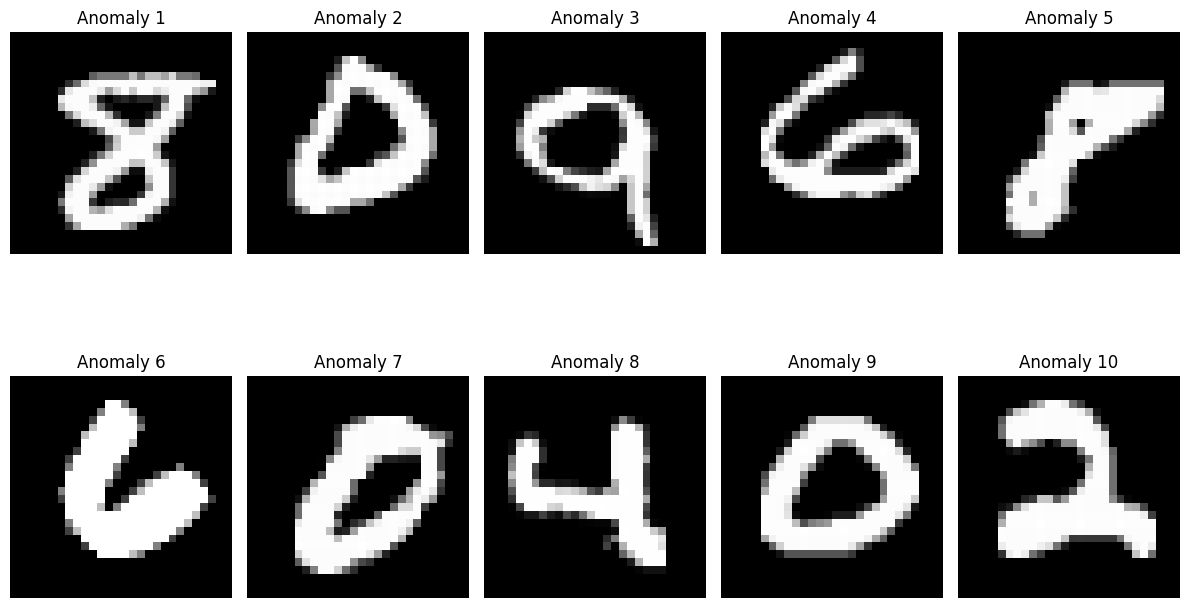

In [55]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_reshaped[idx], cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, anomaly_scores)

# Calculate area under the precision-recall curve
pr_auc = auc(recall, precision)

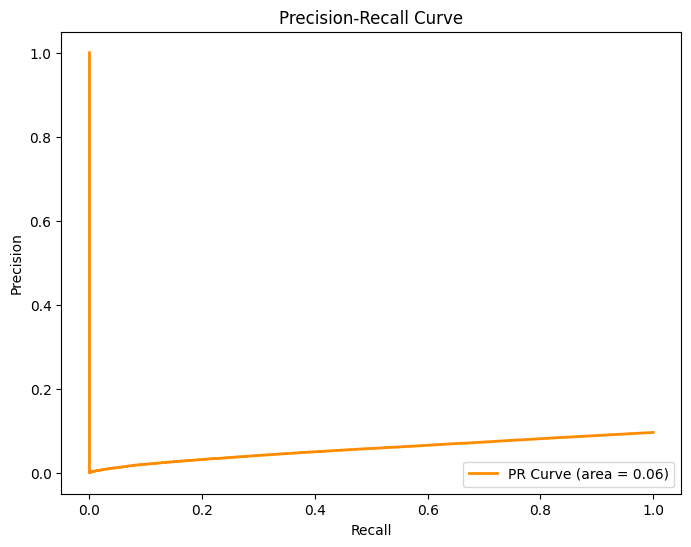

In [57]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

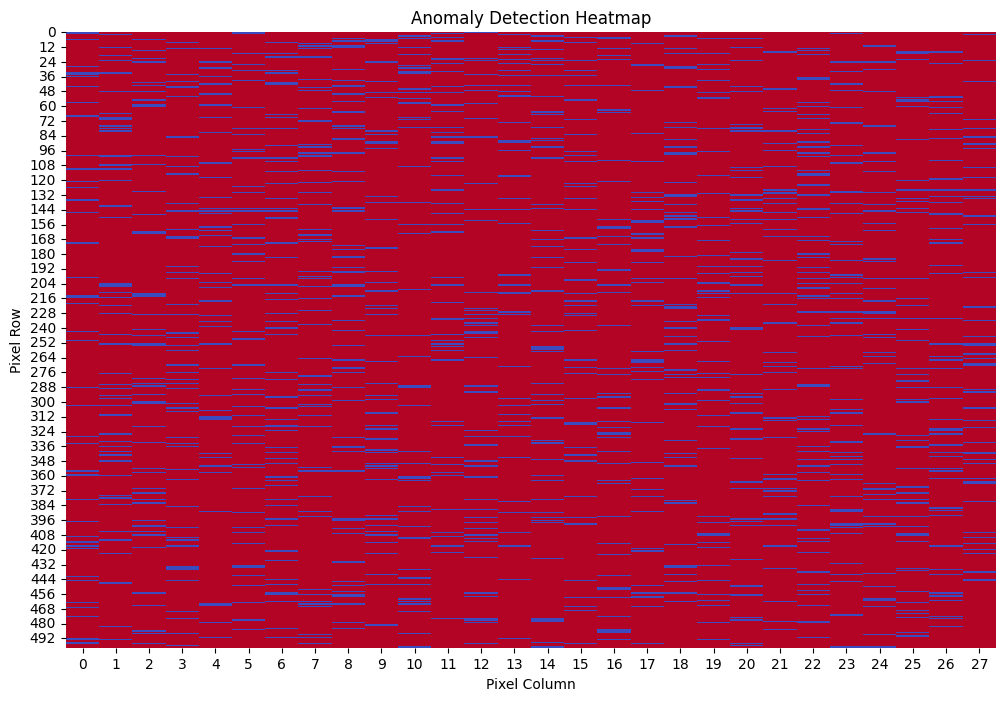

In [58]:
# Create a heatmap of anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(prediction.reshape(-1, 28), cmap='coolwarm', cbar=False)
plt.title('Anomaly Detection Heatmap')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

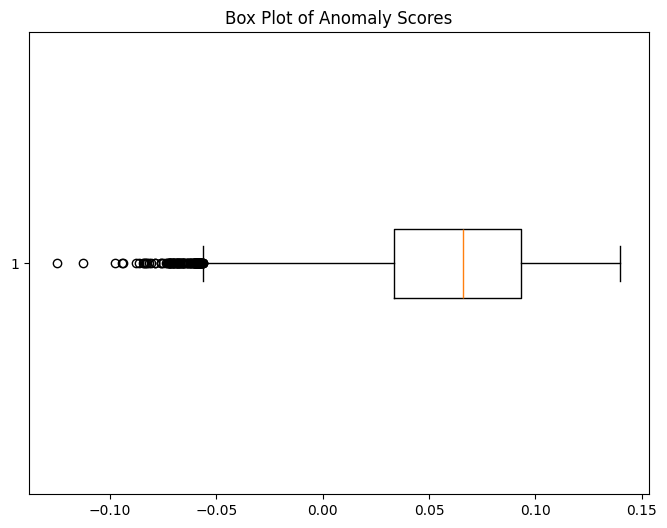

In [59]:
# Create a box plot of anomaly scores
plt.figure(figsize=(8, 6))
plt.boxplot(anomaly_scores, vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.show()